# 2. 베이스라인 코드 공부 및 새로운 피처 구상

**1. Import**

In [1]:
pip install xgboost==1.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

**2. Data Load**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('/content/gdrive/MyDrive/DACON : 악성 URL 분류 AI 경진대회/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/DACON : 악성 URL 분류 AI 경진대회/test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

**3. Feature-Engineering (FE)**

In [6]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자('-', '_', '/') 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

도메인 생성 날짜 칼럼

In [7]:
# whois 라이브러리 설치
!pip install whois

# datetime을 import
import datetime

# 도메인 추출 함수
def extract_domain(url) :
  try :
    return urlparse(url).netloc # URL에서 도메인만 추출
  except :
    return -1

# 도메인 등록 기간 가져오는 함수
def get_domain_creation_date(domain) :
  try :
    w = whois.whois(domain)
    creation_date = w.creation_date

    # 일부 도메인은 리스토로 반환될 수 있음
    if isinstance(creation_date, list) :
      creation_date = creation_date[0]

    # <현재 - 도메인 등록 날짜> 로 도메인이 등록된 기간 확인
    creation_age = (datetime.datetime.now() - creation_date).days

    return creation_age

  except :
    return -1

# train_df, test_df에 도메인 등록 날짜 칼럼 추가
train_df['domain'] = train_df['URL'].apply(extract_domain)
train_df['creation_age'] = train_df['domain'].apply(get_domain_creation_date)
test_df['domain'] = test_df['URL'].apply(extract_domain)
test_df['creation_age'] = test_df['domain'].apply(get_domain_creation_date)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 3.1 MB/s eta 0:00:00


EDA

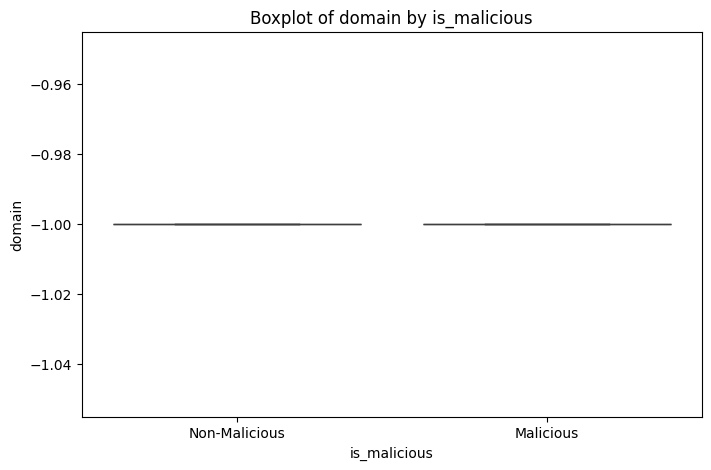

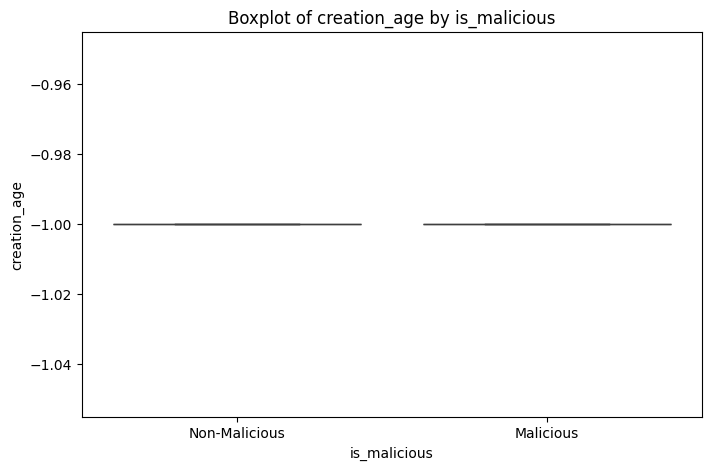

In [8]:
## 악성 여부에 따른 분포 확인
# 변수 목록
variables = ['domain', 'creation_age']

# 박스플롯
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

쿼리 파라미터 개수 칼럼

In [9]:
# 쿼리 파라미터 개수 계산 함수
def count_query_params(url) :
    query_string = url.split('?')[-1] # ? 뒤에 나타나는 문자열을 query_string으로 저장

    if not query_string : # query_string이 비어있으면 0 반환
        return 0

    query_params = query_string.split('&') # &로 분리해 쿼리 파라미터가 있는지 확인

    query_params = [param for param in query_params if '=' in param] # &로 분리한 값 중 '='을 포함하는 것만 계산

    return len(query_params)

train_df['query_params_count'] = train_df['URL'].apply(count_query_params)
test_df['query_params_count'] = train_df['URL'].apply(count_query_params)

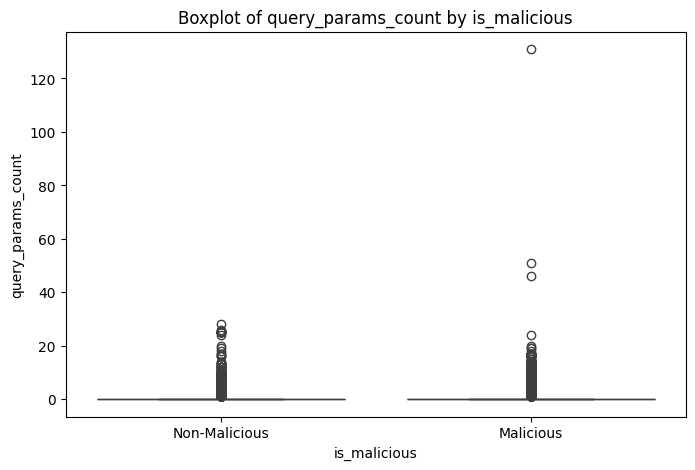

In [10]:
## 악성 여부에 따른 분포 확인
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df, x='label', y='query_params_count')
plt.title(f"Boxplot of query_params_count by is_malicious")
plt.xlabel("is_malicious")
plt.ylabel('query_params_count')
plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
plt.show()

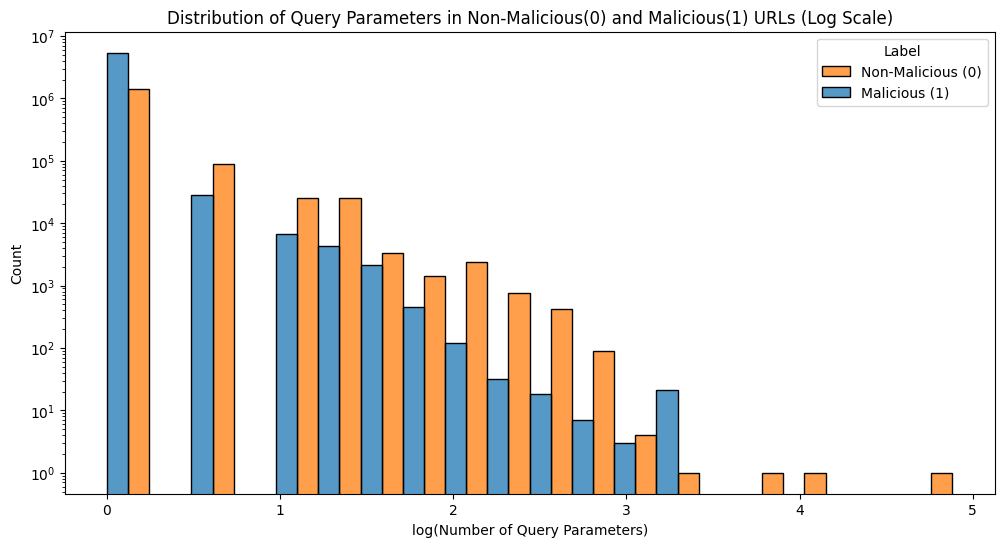

In [11]:
# 쿼리 파라미터에 대한 라벨 분포 확인

# 쿼리 파라미터 칼럼을 로그변환
train_df['log_query_params_count'] = np.log1p(train_df['query_params_count'])

plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x="log_query_params_count", hue="label", bins=20, kde=False, multiple="dodge")
plt.xlabel("log(Number of Query Parameters)")
plt.ylabel("Count")
plt.title("Distribution of Query Parameters in Non-Malicious(0) and Malicious(1) URLs (Log Scale)")
plt.legend(title="Label", labels=["Non-Malicious (0)", "Malicious (1)"])
plt.yscale('log')
plt.show()


In [12]:
# label별로 query_params_count의 value_counts를 구하고 테이블 형식으로 나타내기
table = train_df.groupby("label")["query_params_count"].value_counts().unstack(fill_value=0)

# 결과 출력
print(table)

query_params_count      0      1      2      3     4    5    6     7     8    \
label                                                                          
0                   5387843  28465   6679   4374  2144  347  104    41    81   
1                   1418141  87931  25532  24906  3270  892  542  1167  1228   

query_params_count  9    ...  18   19   20   24   25   26   28   46   51   131  
label                    ...                                                    
0                    24  ...    1    1    1    1   18    1    1    0    0    0  
1                   312  ...    1    2    1    1    0    0    0    1    1    1  

[2 rows x 28 columns]


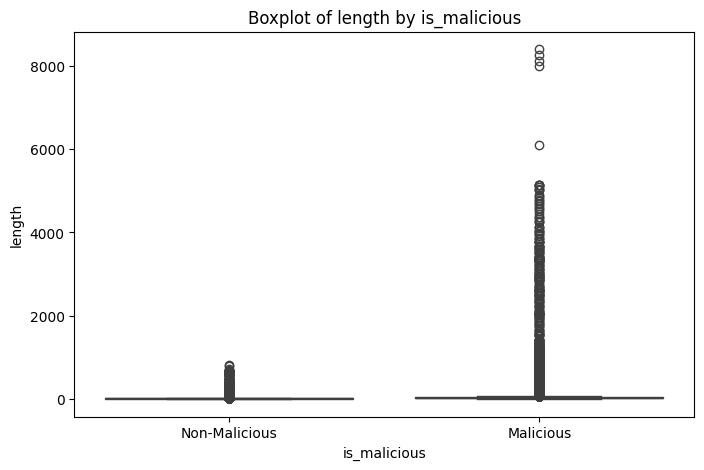

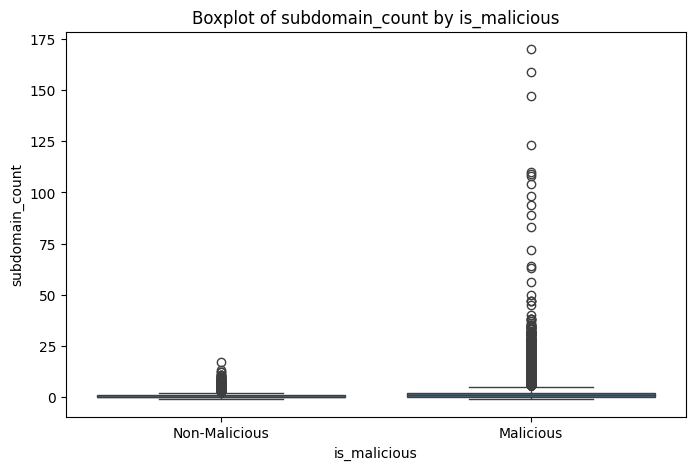

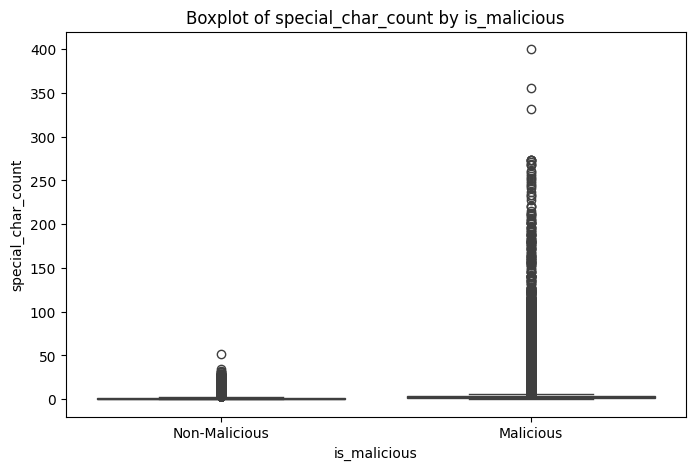

In [13]:
## 악성 여부에 따른 분포 확인
# 변수 목록
variables = ['length', 'subdomain_count', 'special_char_count']
# 박스플롯
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

상관관계 분석

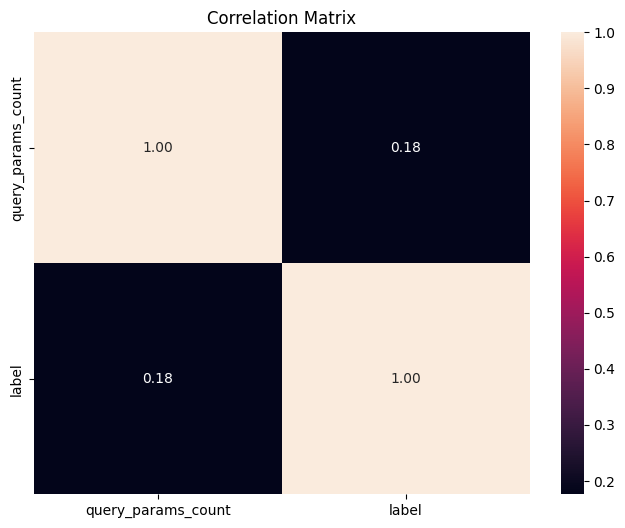

In [14]:
# 상관계수 계산
correlation_matrix = train_df[['query_params_count', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

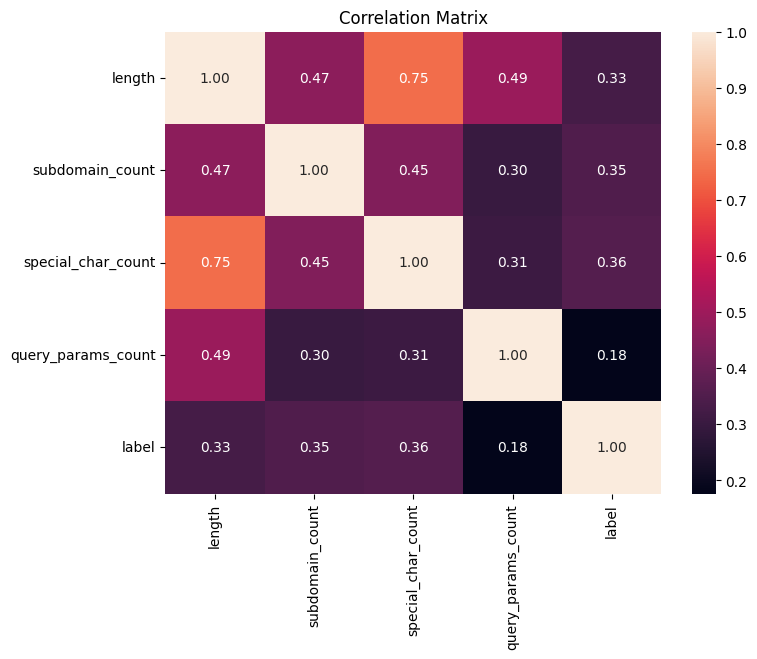

In [15]:
# 상관계수 계산
correlation_matrix = train_df[['length', 'subdomain_count', 'special_char_count', 'query_params_count', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [17]:
## 토크 게시판에서 가져온 칼럼들
# URL 경로의 깊이
train_df['path_depth'] = train_df['URL'].str.count('/')
test_df['path_depth'] = test_df['URL'].str.count('/')


# 연속된 숫자의 길이
import re

train_df['max_numeric_sequence'] = train_df['URL'].apply(lambda x: max([len(seq) for seq in re.findall(r'\d+', x)] or [0]))
test_df['max_numeric_sequence'] = test_df['URL'].apply(lambda x: max([len(seq) for seq in re.findall(r'\d+', x)] or [0]))

In [19]:
## 코드 공유 게시판에서 가져온 칼럼
def extract_additional_features(df):

    # URL 내 숫자 개수 계산
    def count_digits(URL):
        return sum(c.isdigit() for c in URL)

    # URL 내 대문자 개수 계산
    def count_uppercase(URL):
        return sum(c.isupper() for c in URL)

    # URL이 IP 주소를 포함하는지 확인
    def contains_ip(URL):
        return int(bool(re.search(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', URL)))

    # URL에 의심스러운 키워드가 포함되어 있는지 확인
    def contains_suspicious_keywords(URL):
        suspicious_keywords = ["login", "bank", "secure", "update", "verify", "account", "password"]
        return int(any(keyword in URL.lower() for keyword in suspicious_keywords))

    df['digit_count'] = df['URL'].apply(count_digits)
    df['uppercase_count'] = df['URL'].apply(count_uppercase)
    df['ip_address_flag'] = df['URL'].apply(contains_ip)
    df['suspicious_keyword_flag'] = df['URL'].apply(contains_suspicious_keywords)

    return df

# 추가 특징 추출
train_df = extract_additional_features(train_df)
test_df = extract_additional_features(test_df)

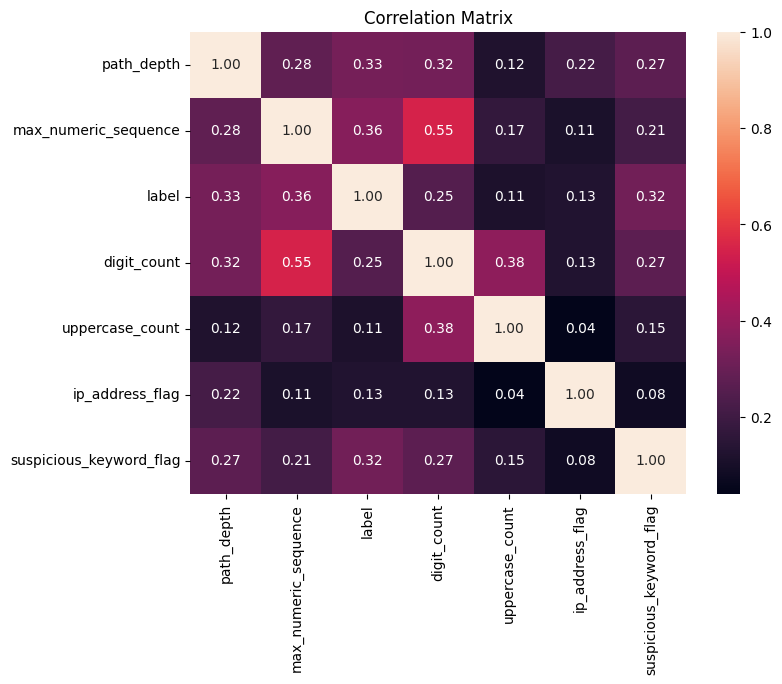

In [20]:
# 상관계수 계산
correlation_matrix = train_df[['path_depth', 'max_numeric_sequence', 'digit_count', 'uppercase_count', 'ip_address_flag', 'suspicious_keyword_flag', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**4. Pre-processing (전처리)**

In [21]:
# 학습을 위한 학습 데이터의 피처와 라벨 준비
X = train_df[['length', 'subdomain_count', 'special_char_count', 'query_params_count', 'path_depth', 'max_numeric_sequence']]
y = train_df['label']

# 추론을 위한 평가 데이터의 피처 준비
X_test = test_df[['length', 'subdomain_count', 'special_char_count', 'query_params_count', 'path_depth', 'max_numeric_sequence']]

**5. K-Fold Model Training (모델 학습)**

In [22]:
# XGBoost 학습 및 모델 저장 (K-Fold)
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []  # 모델을 저장할 리스트
auc_scores = []

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    print('-'*40)
    print(f'Fold {idx + 1} 번째 XGBoost 모델을 학습합니다.')
    print('Epoch|         Train AUC             |         Validation AUC')

    # XGBoost 모델 학습
    model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="auc",
    )

    # 학습 및 Validation 성능 모니터링
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True,
        early_stopping_rounds=5
    )

    models.append(model)  # 모델 저장

    # 검증 데이터 예측 및 ROC-AUC 계산
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    print('-'*40)
    auc_scores.append(auc)

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1 번째 XGBoost 모델을 학습합니다.
Epoch|         Train AUC             |         Validation AUC
[0]	validation_0-auc:0.88460	validation_1-auc:0.88420
[1]	validation_0-auc:0.88559	validation_1-auc:0.88518
[2]	validation_0-auc:0.88699	validation_1-auc:0.88655
[3]	validation_0-auc:0.88728	validation_1-auc:0.88685
[4]	validation_0-auc:0.88775	validation_1-auc:0.88733
[5]	validation_0-auc:0.88818	validation_1-auc:0.88773
[6]	validation_0-auc:0.88840	validation_1-auc:0.88795
[7]	validation_0-auc:0.88854	validation_1-auc:0.88809
[8]	validation_0-auc:0.88904	validation_1-auc:0.88860
[9]	validation_0-auc:0.88916	validation_1-auc:0.88872
[10]	validation_0-auc:0.88944	validation_1-auc:0.88900
[11]	validation_0-auc:0.88978	validation_1-auc:0.88934
[12]	validation_0-auc:0.89008	validation_1-auc:0.88962
[13]	validation_0-auc:0.89033	validation_1-auc:0.88986
[14]	validation_0-auc:0.89052	validation_1-auc:0.89005
[15]	validation_0-auc:0.89070	validation_1-auc:0.8902

**6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)**

In [23]:
# 평가 데이터 추론
# 각 Fold 별 모델의 예측 확률 계산
test_probabilities = np.zeros(len(X_test))

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1] # 악성 URL(1)일 확률 합산

# Soft-Voting 앙상블(Fold 별 모델들의 예측 확률 평균)
test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


**7. Submission (제출 파일 생성)**

In [24]:
# 결과 저장
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('/content/gdrive/MyDrive/DACON : 악성 URL 분류 AI 경진대회/submission.csv', index=False)
print('Done.')

Done.
